---
layout: post
title: Sprint5 Blog
description:  Leaderboard
type: issues 
comments: true
---

Group
The purpose of our group’s program is to create a multiplayer drawing and guessing game inspired by Scribble.io. This program allows players to take turns drawing while others guess the word or phrase being illustrated. The goal is to provide an entertaining and interactive way for people to engage in creative gameplay, fostering collaboration, quick thinking, and creativity.

Individual
My individual feature is primarily focused on making a leaderboard to showcase your scores. This feature allows people to see their highscores, low scores, and challenge themselves with default scores to earn a better score. The purpose of the feature is to also allow for a more gamelike experience for players.



## Fullstack


# Leaderboard API Technical Analysis

## 1. List Requests, Use of Lists, Dictionaries, and Database




## List Requests  
The `get` method retrieves all leaderboard entries and returns them as a JSON response.  

## Use of Lists and Dictionaries  
The `entries` variable is a list of `LeaderboardEntry` objects, and each entry is converted to a dictionary format for the JSON response.  

## Formatting Response Data  

- When the API retrieves data from the database, it formats the results as a list of dictionaries, where:
  - Each row in the database represents a list entry.
  - Each column in the database is stored as key-value pairs in a dictionary.

## Database Queries  
SQLAlchemy is used to query the database, returning Python lists representing rows of data.  

## Methods in Class  
The `_CRUD` class within `LeaderboardAPI` defines methods to create, read, update, and delete entries, working with the columns of the database. 

## Algorithmic Code Request
The API class and methods are defined to handle different types of HTTP requests (GET, POST, DELETE). Each method in the class corresponds to a specific CRUD operation.

### Code:


In [ ]:
from flask import Blueprint, request, g
from flask_restful import Api, Resource
from datetime import datetime
from __init__ import app
from api.jwt_authorize import token_required
from model.leaderboard import LeaderboardEntry

# Create Blueprint for API routing
leaderboard_api = Blueprint('leaderboard_api', __name__, url_prefix='/api')
api = Api(leaderboard_api)

class LeaderboardAPI:
    class _CRUD(Resource):
        @token_required()  # Require authentication
        def post(self):
            """Create or update a leaderboard entry"""
            # Get current authenticated user
            current_user = g.current_user
            data = request.get_json()

            # Validate request data
            if not data or "drawing_name" not in data or "score" not in data:
                return {
                    "message": "Missing required fields",
                    "error": "Bad Request"
                }, 400

            try:
                # Check for existing entry
                existing_entry = LeaderboardEntry.query.filter_by(
                    created_by=current_user.id,
                    drawing_name=data['drawing_name']
                ).first()

                if existing_entry:
                    # Update score if new score is higher
                    if int(data['score']) > existing_entry.score:
                        existing_entry.score = int(data['score'])
                        existing_entry.update()
                        return existing_entry.read(), 200
                    return existing_entry.read(), 200
                else:
                    # Create new entry
                    entry = LeaderboardEntry(
                        profile_name=current_user.name,
                        drawing_name=data['drawing_name'],
                        score=int(data['score']),
                        created_by=current_user.id
                    )
                    entry.create()
                    return entry.read(), 201

            except Exception as e:
                return {
                    "message": "Failed to create/update entry",
                    "error": str(e)
                }, 500

        def get(self):
            """Retrieve all leaderboard entries"""
            try:
                # Query all entries sorted by score
                entries = LeaderboardEntry.query.order_by(
                    LeaderboardEntry.score.desc()
                ).all()
                return [entry.read() for entry in entries]

            except Exception as e:
                return []

        @token_required()  # Require authentication
        def delete(self):
            """Delete a leaderboard entry (Admin only)"""
            current_user = g.current_user
            
            # Check admin role
            if current_user.role != 'Admin':
                return {
                    "message": "Admin access required",
                    "error": "Forbidden"
                }, 403

            # Validate request data
            data = request.get_json()
            if not data or "id" not in data:
                return {
                    "message": "Missing entry ID",
                    "error": "Bad Request"
                }, 400

            try:
                # Find and delete entry
                entry = LeaderboardEntry.query.get(data['id'])
                if not entry:
                    return {
                        "message": "Entry not found", 
                        "error": "Not Found"
                    }, 404

                entry.delete()
                return {
                    "message": "Entry deleted successfully"
                }, 200

            except Exception as e:
                return {
                    "message": "Failed to delete entry",
                    "error": str(e)
                }, 500

    # Register CRUD endpoints
    api.add_resource(_CRUD, '/leaderboard')

## 2. Parameters and Return Type
The body of the request contains JSON data with the following fields:

- profile_name: The name of the player.
- drawing_name: The name of the drawing.
- score: The score achieved.

#### Example:

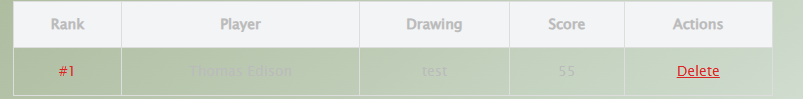

In [ ]:
#  JSON payload 
[
{
        "id": 1,
        "profile_name": "Thomas Edison",
        "drawing_name": "test",
        "score": 55,
        "created_by": "toby"
    },

]

## 4. Call to Algorithm Request

## Definition of Code Block  
The `fetchLeaderboard` function sends a `GET` request to the API endpoint to fetch leaderboard data.  

## Call/Request to the Method  
The Fetch API is used to make the request, and the response is handled asynchronously.  

## Return/Response from the Method  
The response is parsed as JSON and passed to the `displayLeaderboard` function. Errors are logged and displayed in the DOM.  

## Handling Normal and Error Conditions  
The `submitScore` and `deleteEntry` functions handle changing data and trigger different responses based on normal and error conditions.  

#### Code:

In [ ]:
async function fetchLeaderboard() {
    // #1. Definition of Code Block
    // Initialize DOM elements for displaying results
    const messageElement = document.getElementById('message');
    const leaderboardBody = document.getElementById('leaderboard-entries');
    leaderboardBody.innerHTML = '';

    try {
        // #2. Call/Request to the Method
        // Send GET request to API endpoint to fetch leaderboard data
        const response = await fetch(`${pythonURI}/api/leaderboard`, {
            method: "GET"  // GET doesn't need authentication
        });

        // Check for failed response
        if (!response.ok) throw new Error('Failed to load leaderboard');
        
        // #3. Return/Response from the Method
        // Parse JSON response data
        const data = await response.json();

        // Process and display the data in the DOM
        data
            .sort((a, b) => b.score - a.score)  // Sort entries by score
            .forEach((entry, index) => {
                const row = document.createElement('tr');
                row.innerHTML = `
                    <td><span style="color: ${index < 3 ? '#dc2626' : '#666'}">#${index + 1}</span></td>
                    <td>${entry.profile_name}</td>
                    <td>${entry.drawing_name}</td>
                    <td>${entry.score}</td>
                    <td>${entry.created_by ? 
                        `<button class="delete-btn" onclick="deleteEntry(${entry.id})">Delete</button>` 
                        : ''}</td>
                `;
                leaderboardBody.appendChild(row);
            });
        messageElement.textContent = '';

    } catch (error) {
        // #4. Handling Normal and Error Conditions
        // Log error and display error message in DOM
        console.error('Error:', error);
        messageElement.textContent = 'Error loading leaderboard';
        messageElement.className = 'message error';
    }
}

// Example of handling data submission
async function submitScore(event) {
    event.preventDefault();
    const messageElement = document.getElementById('message');
    
    // #1. Definition: Get form data
    const drawingName = document.getElementById('drawingName').value.trim();
    const score = parseInt(document.getElementById('score').value);

    // Validate input
    if (score < 0 || score > 100) {
        messageElement.textContent = 'Score must be between 0 and 100';
        messageElement.className = 'message error';
        return;
    }

    try {
        // #2. Call/Request: Send POST request
        const response = await fetch(`${pythonURI}/api/leaderboard`, {
            ...fetchConfig,
            method: "POST",
            body: JSON.stringify({
                drawing_name: drawingName,
                score: score
            })
        });

        // #3. Return/Response: Handle response
        const data = await response.json();
        
        if (!response.ok) {
            throw new Error(data.message || 'Failed to submit score');
        }

        // #4. Normal Condition: Success handling
        if (response.status === 200) {
            messageElement.textContent = `Score updated! Current best: ${data.score}`;
        } else {
            messageElement.textContent = 'New score submitted successfully!';
        }
        messageElement.className = 'message success';
        this.reset();
        
        await fetchLeaderboard();

    } catch (error) {
        // #4. Error Condition: Error handling
        console.error('Error:', error);
        messageElement.textContent = error.message;
        messageElement.className = 'message error';
    }
}

// Initialize leaderboard when page loads
document.addEventListener('DOMContentLoaded', fetchLeaderboard);